In [ ]:
# (token方向に)AvgPool -> (embed方向に)LayerNorm
# 0.1はwarmup
# gradient_accumulation_steps = 2
# 自作のセパレータををadditional_special_tokensとして追加

Credits to: https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-w-w-b-train and https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

I just applied Abhishek's great code to Nakama's great notebook to create folds grouped by anchors and stratified by score. Does this close the CV-LB gap? Let's see :-)

# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [ ]:
# ====================================================
# CFG
# ====================================================
class CFG:
    
    # General
    exp='030'
    debug=False  # False
    wandb=True
    resume= None  # [None, 'auto', 'allow', 'must']
    save_checkpoint=True
    competition='PPPM'
    seed=42

    # Dataset & DataLoader
    tokenizer_kwargs={
        'do_lower_case': True,
    }
    num_workers=4
    batch_size=16
    max_len=512

    # Model
    model="microsoft/deberta-v3-large"
    fc_dropout=0.2
    target_size=1

    # Optimizer & Scheduler
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    weight_decay=0.01
    max_grad_norm=1000

    # Train
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    epochs=5
    gradient_accumulation_steps=2
    print_freq=100
    apex=True
    train=True
    

if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]


# ====================================================
# Colab settings
# ====================================================
class ColabConfig:
    dataset_name = CFG.competition
    dataset_version = 'exp' + CFG.exp
    dataset_new = True  # 新しいデータセットか
    dataset_dir = None  # Kaggle Dataset にアップロードするディレクトリ
    dataset_note = ''  # 前の版からの変更点
    in_colab = False  # colab上にデータダウンロード

In [ ]:
!nvcc --version
!python -c 'import torch; print(torch.__version__) '
!python --version
print('')
!nvidia-smi
print('')
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
1.11.0+cu113
Python 3.7.13

Sat Jun 18 05:41:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                

In [ ]:
%%time
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
    import os
    print('This environment is Google Colab')

    # mount drive
    from google.colab import drive
    if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/PPPM/exps')

    # kaggle api token and update kaggle api
    from google.colab import files
    if not os.path.isfile('~/.kaggle/kaggle.json'):
        # files.upload()
        !mkdir -p ~/.kaggle
        !cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !pip install --upgrade --force-reinstall --no-deps -q kaggle

    if ColabConfig.in_colab:
        # make directory in colab
        !mkdir -p /content/input
        !mkdir -p /content/working

        # download dataset in colab
        import zipfile, glob
        os.chdir('/content/input')
        # !kaggle competitions download -qc birdclef-2022 -p birdclef-2022
        
        # !mkdir birdclef-2022
        # !cp /content/drive/MyDrive/kaggle/BirdCLEF2022/input/birdclef-2022/* ./birdclef-2022/

        for p in glob.glob('**/*.zip', recursive=True):
            print(p)
            d, f = os.path.split(p)
            # if f in ['']:
            #     continue
            with zipfile.ZipFile(p, 'r') as zipf:
                print('unzip: ', zipf)
                zipf.extractall(d)
                print('remove: ', f)
                os.remove(p)
        
        os.chdir('/content/working')

This environment is Google Colab
Mounted at /content/drive
     |████████████████████████████████| 58 kB 4.2 MB/s 
CPU times: user 892 ms, sys: 175 ms, total: 1.07 s
Wall time: 24.4 s


In [ ]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/PPPM/output/{CFG.exp}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# kaggle dataset config
ColabConfig.dataset_dir = OUTPUT_DIR

# WandB

In [ ]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    !pip install -q wandb
    import wandb

    if CFG.debug:
        anony = "must"
        print('It is debugging.')
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')
    else:
        try:
            # from kaggle_secrets import UserSecretsClient
            # user_secrets = UserSecretsClient()
            # secret_value_0 = user_secrets.get_secret("wandb_api")
            with open('/content/drive/MyDrive/kaggle/wandb') as f:
                wandb_api_key = f.readline().rstrip('\n')
            wandb.login(key=wandb_api_key)
            anony = None
        except:
            anony = "must"
            print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    # https://docs.wandb.ai/ref/python/init
    run = wandb.init(project='PPPM', 
                        name=CFG.exp,
                        config=class2dict(CFG),
                    #  group=CFG.exp,
                        job_type="train",
                        resume=CFG.resume,  # 'auto'
                        # id='3bwalqa8',
                        anonymous=anony)

     |████████████████████████████████| 1.8 MB 8.1 MB/s 
     |████████████████████████████████| 145 kB 73.2 MB/s 
     |████████████████████████████████| 181 kB 62.5 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: y-haneji. Use `wandb login --relogin` to force relogin


# Library

In [ ]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
tqdm.pandas()
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

# # 20分ぐらい
# !pip uninstall -y torch torchvision
# !pip install 'https://download.pytorch.org/whl/cu111/torch-1.10.2%2Bcu111-cp37-cp37m-linux_x86_64.whl' 'https://download.pytorch.org/whl/cu111/torchvision-0.11.3%2Bcu111-cp37-cp37m-linux_x86_64.whl'
# !git clone https://github.com/NVIDIA/apex.git
# %cd apex
# !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
# %cd ..
# # !rm -rf /content/drive/MyDrive/kaggle/PPPM/exps/apex/
# from apex import amp

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('python -m pip install sentencepiece')
os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [ ]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [ ]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [ ]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [ ]:
# ';' を ',' に変換する
def preprocess_context(text: str):
    text = text.replace(';', '.')
    return text

train['context_text'] = train['context_text'].map(preprocess_context)
test['context_text'] = test['context_text'].map(preprocess_context)

In [ ]:
# anchor, target, context_text をそれぞれ一文ずつとみなす
sep1 = '[s1]'
sep2 = '[s2]'
train['text'] = train['anchor'] + '.' + sep1 + train['target'] + '.' + sep2  + train['context_text'] + '.'
test['text'] = test['anchor'] + '.' + sep1 + test['target'] + '.' + sep2 + test['context_text'] + '.'
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement.[s1]abatement of pollution.[s2]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement.[s1]act of abating.[s2]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement.[s1]active catalyst.[s2]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement.[s1]eliminating process.[s2]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement.[s1]forest region.[s2]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum.[s1]inorganic photoconductor drum.[s2...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING. LIGHTING. HEATING. WEA...,adjust gas flow.[s1]altering gas flow.[s2]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS. TRANSPORTING. VEHICLES ...,lower trunnion.[s1]lower locating.[s2]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES. PAPER. TREATMENT OF TEXTILES OR THE ...,cap component.[s1]upper portion.[s2]TEXTILES. ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation.[s1]artificial neural netwo...


# EDA

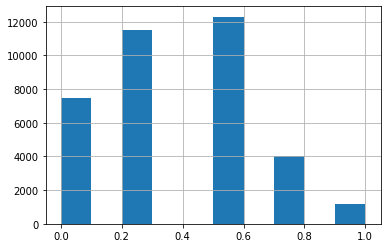

In [ ]:
train['score'].hist()

In [ ]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [ ]:
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

550 183
549 184
550 183
550 183
3    9622
0    9379
1    8860
2    8612
Name: fold, dtype: int64


In [ ]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [ ]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model, **CFG.tokenizer_kwargs)
num_added_tokens = tokenizer.add_special_tokens({'additional_special_tokens': [sep1, sep2]})
print(f"{num_added_tokens} tokens added.")
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/580 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


2 tokens added.


# Dataset

In [ ]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 106


In [ ]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df, phase: str ='train'):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [ ]:
# train_dataset = TrainDataset(CFG, train, 'train')
# inputs, label = train_dataset[0]
# print(inputs)
# print(label)

# Model

In [ ]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.model.resize_token_embeddings(len(cfg.tokenizer))
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self.layer_norm1 = nn.LayerNorm(self.config.hidden_size)
        self._init_weights(self.attention)
        self.linear = nn.Linear(self.config.hidden_size, 1)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_state = outputs[0]
        input_mask_expanded = inputs["attention_mask"].unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        out = sum_embeddings / sum_mask
        
        out = self.layer_norm1(out)
        output = self.fc(out)
                
        return output

# Helpler functions

In [ ]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [ ]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, checkpoint_path=None,):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds, phase='train')
    valid_dataset = TrainDataset(CFG, valid_folds, phase='val')

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size / CFG.gradient_accumulation_steps * CFG.epochs)
    CFG.num_warmup_steps = num_train_steps * 0.1
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.
    epoch = 0

    # if wandb.run.resumed:
    #     checkpoint = torch.load(checkpoint_path)  # wandb.restore(checkpoint_path)
    #     if checkpoint['epoch'] < CFG.epochs-1:  # foldの終わりで止まっている時もある
    #         model.load_state_dict(checkpoint['model'])
    #         optimizer.load_state_dict(checkpoint['optimizer'])
    #         scheduler.load_state_dict(checkpoint['scheduler'])
    #         # amp.load_state_dict(checkpoint['amp'])
    #         epoch = checkpoint['epoch'] + 1  # 保存時のエポックが読み出されるので+1
    #         best_score = checkpoint['best_score']

    while epoch < CFG.epochs:
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if CFG.save_checkpoint:
            torch.save({'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict(),
                        # 'amp': amp.state_dict(),
                        'epoch': epoch,
                        'best_score': best_score},
                        checkpoint_path)
            # wandb.save(checkpoint_path)  # driveでos.symlinkでエラーが出る

        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            
        epoch += 1

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [24]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        fold = 0

        if wandb.run.resumed:
            checkpoint = torch.load(OUTPUT_DIR + 'fold_checkpoint.pth')
            fold = checkpoint['fold'] + 1  # 保存時のfoldが読み出されるので+1
            oof_df = checkpoint['oof_df']

        while fold < CFG.n_fold:
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold, checkpoint_path=OUTPUT_DIR + 'epoch_checkpoint.pth')
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
            if CFG.save_checkpoint:
                torch.save({'fold': fold,
                            'oof_df': oof_df},
                            OUTPUT_DIR + 'fold_checkpoint.pth')
            fold += 1

        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb & (~CFG.debug):
        wandb.finish()

    os.remove(OUTPUT_DIR + 'fold_checkpoint.pth')
    os.remove(OUTPUT_DIR + 'epoch_checkpoint.pth')

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/833M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1693] Elapsed 0m 0s (remain 26m 42s) Loss: 0.3405(0.3405) Grad: 88182.3203  LR: 0.00000000  
Epoch: [1][100/1693] Elapsed 1m 13s (remain 19m 22s) Loss: 0.2964(0.3321) Grad: 24693.5449  LR: 0.00000236  
Epoch: [1][200/1693] Elapsed 2m 26s (remain 18m 5s) Loss: 0.3234(0.3243) Grad: 16151.0332  LR: 0.00000472  
Epoch: [1][300/1693] Elapsed 3m 38s (remain 16m 51s) Loss: 0.3257(0.3194) Grad: 35000.9844  LR: 0.00000709  
Epoch: [1][400/1693] Elapsed 4m 51s (remain 15m 38s) Loss: 0.3675(0.3150) Grad: 56107.7500  LR: 0.00000945  
Epoch: [1][500/1693] Elapsed 6m 3s (remain 14m 25s) Loss: 0.3026(0.3099) Grad: 24003.4551  LR: 0.00001181  
Epoch: [1][600/1693] Elapsed 7m 16s (remain 13m 13s) Loss: 0.2863(0.3076) Grad: 15558.8477  LR: 0.00001417  
Epoch: [1][700/1693] Elapsed 8m 29s (remain 12m 0s) Loss: 0.2333(0.3046) Grad: 13609.1055  LR: 0.00001654  
Epoch: [1][800/1693] Elapsed 9m 41s (remain 10m 47s) Loss: 0.2630(0.3013) Grad: 21442.7246  LR: 0.00001890  
Epoch: [1][900/1693] Elap

Epoch 1 - avg_train_loss: 0.2894  avg_val_loss: 0.2735  time: 1349s
Epoch 1 - Score: 0.8198


EVAL: [586/587] Elapsed 1m 59s (remain 0m 0s) Loss: 0.3361(0.2735) 


Epoch 1 - Save Best Score: 0.8198 Model


Epoch: [2][0/1693] Elapsed 0m 1s (remain 36m 39s) Loss: 0.2325(0.2325) Grad: 84163.9453  LR: 0.00001940  
Epoch: [2][100/1693] Elapsed 1m 15s (remain 19m 44s) Loss: 0.2866(0.2684) Grad: 50025.6484  LR: 0.00001925  
Epoch: [2][200/1693] Elapsed 2m 28s (remain 18m 24s) Loss: 0.2724(0.2694) Grad: 97514.8047  LR: 0.00001909  
Epoch: [2][300/1693] Elapsed 3m 41s (remain 17m 3s) Loss: 0.2448(0.2704) Grad: 28518.5078  LR: 0.00001891  
Epoch: [2][400/1693] Elapsed 4m 53s (remain 15m 46s) Loss: 0.2394(0.2698) Grad: 20839.6523  LR: 0.00001871  
Epoch: [2][500/1693] Elapsed 6m 6s (remain 14m 31s) Loss: 0.2468(0.2686) Grad: 23815.9102  LR: 0.00001850  
Epoch: [2][600/1693] Elapsed 7m 19s (remain 13m 17s) Loss: 0.2970(0.2680) Grad: 19889.4336  LR: 0.00001828  
Epoch: [2][700/1693] Elapsed 8m 31s (remain 12m 4s) Loss: 0.2851(0.2680) Grad: 17972.6113  LR: 0.00001804  
Epoch: [2][800/1693] Elapsed 9m 44s (remain 10m 50s) Loss: 0.3093(0.2679) Grad: 38637.6719  LR: 0.00001779  
Epoch: [2][900/1693] Elap

Epoch 2 - avg_train_loss: 0.2671  avg_val_loss: 0.2742  time: 1351s
Epoch 2 - Score: 0.8340


EVAL: [586/587] Elapsed 1m 59s (remain 0m 0s) Loss: 0.3473(0.2742) 


Epoch 2 - Save Best Score: 0.8340 Model


Epoch: [3][0/1693] Elapsed 0m 1s (remain 30m 48s) Loss: 0.2641(0.2641) Grad: 77381.7031  LR: 0.00001501  
Epoch: [3][100/1693] Elapsed 1m 14s (remain 19m 40s) Loss: 0.2954(0.2625) Grad: 43584.9492  LR: 0.00001465  
Epoch: [3][200/1693] Elapsed 2m 27s (remain 18m 18s) Loss: 0.2211(0.2624) Grad: 34613.5234  LR: 0.00001428  
Epoch: [3][300/1693] Elapsed 3m 40s (remain 17m 0s) Loss: 0.2795(0.2625) Grad: 60924.7109  LR: 0.00001390  
Epoch: [3][400/1693] Elapsed 4m 53s (remain 15m 44s) Loss: 0.2693(0.2608) Grad: 78802.9062  LR: 0.00001352  
Epoch: [3][500/1693] Elapsed 6m 5s (remain 14m 30s) Loss: 0.2537(0.2616) Grad: 101142.4453  LR: 0.00001313  
Epoch: [3][600/1693] Elapsed 7m 18s (remain 13m 16s) Loss: 0.2540(0.2618) Grad: 31654.7949  LR: 0.00001274  
Epoch: [3][700/1693] Elapsed 8m 31s (remain 12m 3s) Loss: 0.2693(0.2616) Grad: 47063.7812  LR: 0.00001234  
Epoch: [3][800/1693] Elapsed 9m 43s (remain 10m 49s) Loss: 0.2319(0.2612) Grad: 31331.1777  LR: 0.00001194  
Epoch: [3][900/1693] Ela

Epoch 3 - avg_train_loss: 0.2597  avg_val_loss: 0.2708  time: 1351s
Epoch 3 - Score: 0.8419


EVAL: [586/587] Elapsed 1m 59s (remain 0m 0s) Loss: 0.3340(0.2708) 


Epoch 3 - Save Best Score: 0.8419 Model


Epoch: [4][0/1693] Elapsed 0m 0s (remain 26m 24s) Loss: 0.3379(0.3379) Grad: 55954.8398  LR: 0.00000828  
Epoch: [4][100/1693] Elapsed 1m 14s (remain 19m 41s) Loss: 0.2433(0.2569) Grad: 45569.9961  LR: 0.00000787  
Epoch: [4][200/1693] Elapsed 2m 27s (remain 18m 17s) Loss: 0.2463(0.2561) Grad: 53701.2695  LR: 0.00000747  
Epoch: [4][300/1693] Elapsed 3m 40s (remain 16m 59s) Loss: 0.2347(0.2566) Grad: 86723.5938  LR: 0.00000708  
Epoch: [4][400/1693] Elapsed 4m 53s (remain 15m 45s) Loss: 0.2219(0.2554) Grad: 59012.0664  LR: 0.00000668  
Epoch: [4][500/1693] Elapsed 6m 5s (remain 14m 30s) Loss: 0.3027(0.2565) Grad: 90753.8359  LR: 0.00000630  
Epoch: [4][600/1693] Elapsed 7m 18s (remain 13m 16s) Loss: 0.2722(0.2570) Grad: 33362.1289  LR: 0.00000592  
Epoch: [4][700/1693] Elapsed 8m 31s (remain 12m 3s) Loss: 0.3041(0.2566) Grad: 58352.7578  LR: 0.00000555  
Epoch: [4][800/1693] Elapsed 9m 43s (remain 10m 50s) Loss: 0.2746(0.2566) Grad: 102343.1250  LR: 0.00000518  
Epoch: [4][900/1693] El

Epoch 4 - avg_train_loss: 0.2558  avg_val_loss: 0.2734  time: 1351s
Epoch 4 - Score: 0.8406


EVAL: [586/587] Elapsed 1m 59s (remain 0m 0s) Loss: 0.3383(0.2734) 
Epoch: [5][0/1693] Elapsed 0m 0s (remain 26m 41s) Loss: 0.2633(0.2633) Grad: 33949.7773  LR: 0.00000235  
Epoch: [5][100/1693] Elapsed 1m 14s (remain 19m 33s) Loss: 0.2394(0.2530) Grad: 51746.2031  LR: 0.00000209  
Epoch: [5][200/1693] Elapsed 2m 27s (remain 18m 14s) Loss: 0.2750(0.2552) Grad: 11674.0889  LR: 0.00000185  
Epoch: [5][300/1693] Elapsed 3m 40s (remain 16m 57s) Loss: 0.2698(0.2549) Grad: 17365.9375  LR: 0.00000162  
Epoch: [5][400/1693] Elapsed 4m 52s (remain 15m 43s) Loss: 0.2587(0.2555) Grad: 86168.4922  LR: 0.00000140  
Epoch: [5][500/1693] Elapsed 6m 5s (remain 14m 29s) Loss: 0.2674(0.2553) Grad: 44088.0859  LR: 0.00000120  
Epoch: [5][600/1693] Elapsed 7m 17s (remain 13m 15s) Loss: 0.3135(0.2551) Grad: 44365.6719  LR: 0.00000101  
Epoch: [5][700/1693] Elapsed 8m 30s (remain 12m 2s) Loss: 0.2212(0.2552) Grad: 76958.9922  LR: 0.00000083  
Epoch: [5][800/1693] Elapsed 9m 43s (remain 10m 49s) Loss: 0.2562

Epoch 5 - avg_train_loss: 0.2539  avg_val_loss: 0.2727  time: 1350s
Epoch 5 - Score: 0.8423


EVAL: [586/587] Elapsed 1m 59s (remain 0m 0s) Loss: 0.3368(0.2727) 


Epoch 5 - Save Best Score: 0.8423 Model
========== fold: 0 result ==========
Score: 0.8423
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exact

Epoch: [1][0/1725] Elapsed 0m 1s (remain 46m 46s) Loss: 0.5134(0.5134) Grad: inf  LR: 0.00000000  
Epoch: [1][100/1725] Elapsed 1m 15s (remain 20m 11s) Loss: 0.3398(0.4499) Grad: 17432.8652  LR: 0.00000232  
Epoch: [1][200/1725] Elapsed 2m 28s (remain 18m 42s) Loss: 0.3036(0.3855) Grad: 14408.7148  LR: 0.00000464  
Epoch: [1][300/1725] Elapsed 3m 40s (remain 17m 23s) Loss: 0.3209(0.3573) Grad: 9950.6572  LR: 0.00000695  
Epoch: [1][400/1725] Elapsed 4m 53s (remain 16m 8s) Loss: 0.2994(0.3418) Grad: 7672.9180  LR: 0.00000927  
Epoch: [1][500/1725] Elapsed 6m 5s (remain 14m 54s) Loss: 0.2689(0.3318) Grad: 17834.6875  LR: 0.00001159  
Epoch: [1][600/1725] Elapsed 7m 18s (remain 13m 40s) Loss: 0.2663(0.3247) Grad: 29530.9062  LR: 0.00001391  
Epoch: [1][700/1725] Elapsed 8m 31s (remain 12m 26s) Loss: 0.2676(0.3193) Grad: 25395.1562  LR: 0.00001623  
Epoch: [1][800/1725] Elapsed 9m 43s (remain 11m 13s) Loss: 0.2201(0.3150) Grad: 13158.5898  LR: 0.00001854  
Epoch: [1][900/1725] Elapsed 10m 

Epoch 1 - avg_train_loss: 0.2955  avg_val_loss: 0.2846  time: 1368s
Epoch 1 - Score: 0.7959


EVAL: [553/554] Elapsed 1m 52s (remain 0m 0s) Loss: 0.2544(0.2846) 


Epoch 1 - Save Best Score: 0.7959 Model


Epoch: [2][0/1725] Elapsed 0m 1s (remain 33m 43s) Loss: 0.2805(0.2805) Grad: 115193.7969  LR: 0.00001940  
Epoch: [2][100/1725] Elapsed 1m 15s (remain 20m 7s) Loss: 0.2761(0.2725) Grad: 70422.3047  LR: 0.00001925  
Epoch: [2][200/1725] Elapsed 2m 27s (remain 18m 40s) Loss: 0.2208(0.2685) Grad: 68311.0234  LR: 0.00001909  
Epoch: [2][300/1725] Elapsed 3m 40s (remain 17m 23s) Loss: 0.2836(0.2679) Grad: 41421.8672  LR: 0.00001892  
Epoch: [2][400/1725] Elapsed 4m 53s (remain 16m 7s) Loss: 0.2326(0.2677) Grad: 44870.1641  LR: 0.00001873  
Epoch: [2][500/1725] Elapsed 6m 5s (remain 14m 53s) Loss: 0.3035(0.2664) Grad: 49353.5547  LR: 0.00001852  
Epoch: [2][600/1725] Elapsed 7m 18s (remain 13m 40s) Loss: 0.2525(0.2661) Grad: 50209.0078  LR: 0.00001830  
Epoch: [2][700/1725] Elapsed 8m 31s (remain 12m 26s) Loss: 0.2452(0.2653) Grad: 133851.3438  LR: 0.00001807  
Epoch: [2][800/1725] Elapsed 9m 43s (remain 11m 13s) Loss: 0.2556(0.2644) Grad: 88732.1094  LR: 0.00001783  
Epoch: [2][900/1725] El

Epoch 2 - avg_train_loss: 0.2643  avg_val_loss: 0.2727  time: 1368s
Epoch 2 - Score: 0.8227


EVAL: [553/554] Elapsed 1m 52s (remain 0m 0s) Loss: 0.2474(0.2727) 


Epoch 2 - Save Best Score: 0.8227 Model


Epoch: [3][0/1725] Elapsed 0m 0s (remain 28m 22s) Loss: 0.3043(0.3043) Grad: 70841.4375  LR: 0.00001501  
Epoch: [3][100/1725] Elapsed 1m 14s (remain 20m 1s) Loss: 0.3166(0.2597) Grad: 111570.7266  LR: 0.00001466  
Epoch: [3][200/1725] Elapsed 2m 28s (remain 18m 42s) Loss: 0.2735(0.2554) Grad: 66087.2891  LR: 0.00001430  
Epoch: [3][300/1725] Elapsed 3m 40s (remain 17m 24s) Loss: 0.2381(0.2561) Grad: 34948.3164  LR: 0.00001393  
Epoch: [3][400/1725] Elapsed 4m 53s (remain 16m 8s) Loss: 0.2984(0.2573) Grad: 84298.0391  LR: 0.00001355  
Epoch: [3][500/1725] Elapsed 6m 6s (remain 14m 54s) Loss: 0.2759(0.2582) Grad: 130313.4375  LR: 0.00001317  
Epoch: [3][600/1725] Elapsed 7m 18s (remain 13m 40s) Loss: 0.2755(0.2598) Grad: 24897.7637  LR: 0.00001278  
Epoch: [3][700/1725] Elapsed 8m 31s (remain 12m 27s) Loss: 0.2768(0.2597) Grad: 50077.2695  LR: 0.00001239  
Epoch: [3][800/1725] Elapsed 9m 44s (remain 11m 13s) Loss: 0.2583(0.2601) Grad: 130424.3047  LR: 0.00001200  
Epoch: [3][900/1725] E

Epoch 3 - avg_train_loss: 0.2599  avg_val_loss: 0.2738  time: 1369s
Epoch 3 - Score: 0.8248


EVAL: [553/554] Elapsed 1m 52s (remain 0m 0s) Loss: 0.2470(0.2738) 


Epoch 3 - Save Best Score: 0.8248 Model


Epoch: [4][0/1725] Elapsed 0m 1s (remain 34m 25s) Loss: 0.3195(0.3195) Grad: 74383.8516  LR: 0.00000828  
Epoch: [4][100/1725] Elapsed 1m 15s (remain 20m 7s) Loss: 0.2344(0.2553) Grad: 29670.8086  LR: 0.00000789  
Epoch: [4][200/1725] Elapsed 2m 28s (remain 18m 46s) Loss: 0.2426(0.2541) Grad: 137040.0625  LR: 0.00000749  
Epoch: [4][300/1725] Elapsed 3m 41s (remain 17m 26s) Loss: 0.2623(0.2546) Grad: 38435.3359  LR: 0.00000710  
Epoch: [4][400/1725] Elapsed 4m 53s (remain 16m 10s) Loss: 0.1948(0.2556) Grad: 195169.3125  LR: 0.00000672  
Epoch: [4][500/1725] Elapsed 6m 6s (remain 14m 55s) Loss: 0.2799(0.2565) Grad: 35220.8945  LR: 0.00000634  
Epoch: [4][600/1725] Elapsed 7m 19s (remain 13m 41s) Loss: 0.2730(0.2559) Grad: 33150.2930  LR: 0.00000597  
Epoch: [4][700/1725] Elapsed 8m 32s (remain 12m 27s) Loss: 0.2911(0.2556) Grad: 65445.5977  LR: 0.00000560  
Epoch: [4][800/1725] Elapsed 9m 44s (remain 11m 14s) Loss: 0.2660(0.2567) Grad: 30348.5391  LR: 0.00000524  
Epoch: [4][900/1725] E

Epoch 4 - avg_train_loss: 0.2571  avg_val_loss: 0.2762  time: 1369s
Epoch 4 - Score: 0.8244


EVAL: [553/554] Elapsed 1m 52s (remain 0m 0s) Loss: 0.2463(0.2762) 
Epoch: [5][0/1725] Elapsed 0m 0s (remain 27m 29s) Loss: 0.1912(0.1912) Grad: 125897.3984  LR: 0.00000236  
Epoch: [5][100/1725] Elapsed 1m 14s (remain 20m 0s) Loss: 0.2496(0.2492) Grad: 84950.8750  LR: 0.00000210  
Epoch: [5][200/1725] Elapsed 2m 27s (remain 18m 38s) Loss: 0.1823(0.2540) Grad: 34256.0430  LR: 0.00000186  
Epoch: [5][300/1725] Elapsed 3m 40s (remain 17m 21s) Loss: 0.2909(0.2556) Grad: 22232.9102  LR: 0.00000163  
Epoch: [5][400/1725] Elapsed 4m 53s (remain 16m 7s) Loss: 0.2632(0.2583) Grad: 36197.2852  LR: 0.00000142  
Epoch: [5][500/1725] Elapsed 6m 5s (remain 14m 53s) Loss: 0.1754(0.2581) Grad: 43651.5469  LR: 0.00000122  
Epoch: [5][600/1725] Elapsed 7m 18s (remain 13m 39s) Loss: 0.2334(0.2570) Grad: 38699.4023  LR: 0.00000103  
Epoch: [5][700/1725] Elapsed 8m 30s (remain 12m 26s) Loss: 0.2726(0.2557) Grad: 142707.0000  LR: 0.00000086  
Epoch: [5][800/1725] Elapsed 9m 43s (remain 11m 13s) Loss: 0.274

Epoch 5 - avg_train_loss: 0.2554  avg_val_loss: 0.2763  time: 1368s
Epoch 5 - Score: 0.8248


EVAL: [553/554] Elapsed 1m 52s (remain 0m 0s) Loss: 0.2461(0.2763) 


Epoch 5 - Save Best Score: 0.8248 Model
========== fold: 1 result ==========
Score: 0.8248
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exact

Epoch: [1][0/1741] Elapsed 0m 1s (remain 37m 53s) Loss: 0.3539(0.3539) Grad: inf  LR: 0.00000000  
Epoch: [1][100/1741] Elapsed 1m 15s (remain 20m 24s) Loss: 0.3142(0.3376) Grad: 19537.7383  LR: 0.00000230  
Epoch: [1][200/1741] Elapsed 2m 28s (remain 18m 54s) Loss: 0.2997(0.3277) Grad: 14574.8428  LR: 0.00000459  
Epoch: [1][300/1741] Elapsed 3m 40s (remain 17m 36s) Loss: 0.3143(0.3203) Grad: 38187.3945  LR: 0.00000689  
Epoch: [1][400/1741] Elapsed 4m 53s (remain 16m 21s) Loss: 0.2711(0.3163) Grad: 65362.2188  LR: 0.00000919  
Epoch: [1][500/1741] Elapsed 6m 6s (remain 15m 6s) Loss: 0.3132(0.3128) Grad: 11841.2393  LR: 0.00001149  
Epoch: [1][600/1741] Elapsed 7m 19s (remain 13m 53s) Loss: 0.2986(0.3094) Grad: 28923.4082  LR: 0.00001378  
Epoch: [1][700/1741] Elapsed 8m 31s (remain 12m 39s) Loss: 0.3167(0.3059) Grad: 29692.8066  LR: 0.00001608  
Epoch: [1][800/1741] Elapsed 9m 44s (remain 11m 26s) Loss: 0.3083(0.3035) Grad: 27277.8184  LR: 0.00001838  
Epoch: [1][900/1741] Elapsed 10

Epoch 1 - avg_train_loss: 0.2906  avg_val_loss: 0.2734  time: 1379s
Epoch 1 - Score: 0.8039


EVAL: [538/539] Elapsed 1m 49s (remain 0m 0s) Loss: 0.1745(0.2734) 


Epoch 1 - Save Best Score: 0.8039 Model


Epoch: [2][0/1741] Elapsed 0m 1s (remain 35m 49s) Loss: 0.2869(0.2869) Grad: 65718.7031  LR: 0.00001940  
Epoch: [2][100/1741] Elapsed 1m 15s (remain 20m 27s) Loss: 0.3306(0.2711) Grad: 139995.8125  LR: 0.00001925  
Epoch: [2][200/1741] Elapsed 2m 28s (remain 18m 57s) Loss: 0.2506(0.2688) Grad: 34472.5781  LR: 0.00001909  
Epoch: [2][300/1741] Elapsed 3m 41s (remain 17m 37s) Loss: 0.2698(0.2689) Grad: 14358.9805  LR: 0.00001892  
Epoch: [2][400/1741] Elapsed 4m 53s (remain 16m 22s) Loss: 0.2573(0.2703) Grad: 37025.7617  LR: 0.00001873  
Epoch: [2][500/1741] Elapsed 6m 6s (remain 15m 7s) Loss: 0.2335(0.2698) Grad: 41140.1055  LR: 0.00001853  
Epoch: [2][600/1741] Elapsed 7m 19s (remain 13m 53s) Loss: 0.2817(0.2693) Grad: 23123.6367  LR: 0.00001831  
Epoch: [2][700/1741] Elapsed 8m 32s (remain 12m 40s) Loss: 0.2972(0.2691) Grad: 25461.3145  LR: 0.00001808  
Epoch: [2][800/1741] Elapsed 9m 45s (remain 11m 26s) Loss: 0.3151(0.2688) Grad: 76478.6875  LR: 0.00001784  
Epoch: [2][900/1741] El

Epoch 2 - avg_train_loss: 0.2672  avg_val_loss: 0.2668  time: 1379s
Epoch 2 - Score: 0.8364


EVAL: [538/539] Elapsed 1m 49s (remain 0m 0s) Loss: 0.1941(0.2668) 


Epoch 2 - Save Best Score: 0.8364 Model


Epoch: [3][0/1741] Elapsed 0m 1s (remain 42m 46s) Loss: 0.2760(0.2760) Grad: 67322.2891  LR: 0.00001501  
Epoch: [3][100/1741] Elapsed 1m 15s (remain 20m 34s) Loss: 0.2934(0.2655) Grad: 48143.5664  LR: 0.00001466  
Epoch: [3][200/1741] Elapsed 2m 29s (remain 19m 1s) Loss: 0.3268(0.2617) Grad: 192833.7344  LR: 0.00001430  
Epoch: [3][300/1741] Elapsed 3m 41s (remain 17m 40s) Loss: 0.2063(0.2594) Grad: 53189.3125  LR: 0.00001393  
Epoch: [3][400/1741] Elapsed 4m 54s (remain 16m 24s) Loss: 0.2396(0.2613) Grad: 22538.0605  LR: 0.00001356  
Epoch: [3][500/1741] Elapsed 6m 7s (remain 15m 8s) Loss: 0.2114(0.2609) Grad: 33415.6133  LR: 0.00001318  
Epoch: [3][600/1741] Elapsed 7m 19s (remain 13m 54s) Loss: 0.2623(0.2611) Grad: 106381.1641  LR: 0.00001280  
Epoch: [3][700/1741] Elapsed 8m 32s (remain 12m 40s) Loss: 0.2415(0.2611) Grad: 41011.0078  LR: 0.00001241  
Epoch: [3][800/1741] Elapsed 9m 45s (remain 11m 27s) Loss: 0.2153(0.2609) Grad: 63644.7773  LR: 0.00001202  
Epoch: [3][900/1741] El

Epoch 3 - avg_train_loss: 0.2605  avg_val_loss: 0.2688  time: 1380s
Epoch 3 - Score: 0.8411


EVAL: [538/539] Elapsed 1m 49s (remain 0m 0s) Loss: 0.1918(0.2688) 


Epoch 3 - Save Best Score: 0.8411 Model


Epoch: [4][0/1741] Elapsed 0m 1s (remain 29m 40s) Loss: 0.2794(0.2794) Grad: 93780.4688  LR: 0.00000828  
Epoch: [4][100/1741] Elapsed 1m 15s (remain 20m 24s) Loss: 0.2552(0.2529) Grad: 130716.2344  LR: 0.00000788  
Epoch: [4][200/1741] Elapsed 2m 28s (remain 18m 56s) Loss: 0.2322(0.2590) Grad: 57999.2812  LR: 0.00000749  
Epoch: [4][300/1741] Elapsed 3m 41s (remain 17m 37s) Loss: 0.2793(0.2589) Grad: 37627.9141  LR: 0.00000711  
Epoch: [4][400/1741] Elapsed 4m 53s (remain 16m 21s) Loss: 0.2833(0.2589) Grad: 27271.0312  LR: 0.00000673  
Epoch: [4][500/1741] Elapsed 6m 6s (remain 15m 7s) Loss: 0.1776(0.2570) Grad: 29396.0234  LR: 0.00000635  
Epoch: [4][600/1741] Elapsed 7m 19s (remain 13m 53s) Loss: 0.2648(0.2573) Grad: 38334.0977  LR: 0.00000598  
Epoch: [4][700/1741] Elapsed 8m 31s (remain 12m 39s) Loss: 0.3209(0.2568) Grad: 461621.4688  LR: 0.00000562  
Epoch: [4][800/1741] Elapsed 9m 44s (remain 11m 26s) Loss: 0.2484(0.2574) Grad: 57743.9648  LR: 0.00000526  
Epoch: [4][900/1741] E

Epoch 4 - avg_train_loss: 0.2568  avg_val_loss: 0.2692  time: 1379s
Epoch 4 - Score: 0.8443


EVAL: [538/539] Elapsed 1m 49s (remain 0m 0s) Loss: 0.1893(0.2692) 


Epoch 4 - Save Best Score: 0.8443 Model


Epoch: [5][0/1741] Elapsed 0m 1s (remain 34m 30s) Loss: 0.2595(0.2595) Grad: 103799.7812  LR: 0.00000235  
Epoch: [5][100/1741] Elapsed 1m 14s (remain 20m 16s) Loss: 0.2987(0.2578) Grad: 52590.9297  LR: 0.00000210  
Epoch: [5][200/1741] Elapsed 2m 28s (remain 18m 56s) Loss: 0.2421(0.2570) Grad: 24400.4199  LR: 0.00000186  
Epoch: [5][300/1741] Elapsed 3m 41s (remain 17m 38s) Loss: 0.2790(0.2567) Grad: 21730.3105  LR: 0.00000163  
Epoch: [5][400/1741] Elapsed 4m 54s (remain 16m 22s) Loss: 0.2717(0.2567) Grad: 23595.5996  LR: 0.00000142  
Epoch: [5][500/1741] Elapsed 6m 6s (remain 15m 7s) Loss: 0.2538(0.2560) Grad: 23973.8984  LR: 0.00000122  
Epoch: [5][600/1741] Elapsed 7m 19s (remain 13m 53s) Loss: 0.2909(0.2562) Grad: 34418.5312  LR: 0.00000104  
Epoch: [5][700/1741] Elapsed 8m 32s (remain 12m 39s) Loss: 0.2940(0.2565) Grad: 13930.8477  LR: 0.00000087  
Epoch: [5][800/1741] Elapsed 9m 44s (remain 11m 26s) Loss: 0.2464(0.2565) Grad: 43009.8438  LR: 0.00000071  
Epoch: [5][900/1741] El

Epoch 5 - avg_train_loss: 0.2548  avg_val_loss: 0.2692  time: 1379s
Epoch 5 - Score: 0.8445


EVAL: [538/539] Elapsed 1m 49s (remain 0m 0s) Loss: 0.1798(0.2692) 


Epoch 5 - Save Best Score: 0.8445 Model
========== fold: 2 result ==========
Score: 0.8445
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exact

Epoch: [1][0/1678] Elapsed 0m 1s (remain 38m 59s) Loss: 0.3631(0.3631) Grad: inf  LR: 0.00000000  
Epoch: [1][100/1678] Elapsed 1m 15s (remain 19m 36s) Loss: 0.3568(0.3516) Grad: 18882.0820  LR: 0.00000238  
Epoch: [1][200/1678] Elapsed 2m 28s (remain 18m 8s) Loss: 0.3119(0.3349) Grad: 12128.9961  LR: 0.00000477  
Epoch: [1][300/1678] Elapsed 3m 40s (remain 16m 50s) Loss: 0.3251(0.3255) Grad: 15836.6562  LR: 0.00000715  
Epoch: [1][400/1678] Elapsed 4m 53s (remain 15m 35s) Loss: 0.2989(0.3184) Grad: 11026.2236  LR: 0.00000954  
Epoch: [1][500/1678] Elapsed 6m 6s (remain 14m 20s) Loss: 0.3118(0.3135) Grad: 19874.1445  LR: 0.00001192  
Epoch: [1][600/1678] Elapsed 7m 19s (remain 13m 6s) Loss: 0.3189(0.3098) Grad: 17362.3965  LR: 0.00001430  
Epoch: [1][700/1678] Elapsed 8m 31s (remain 11m 53s) Loss: 0.2792(0.3062) Grad: 6972.3452  LR: 0.00001669  
Epoch: [1][800/1678] Elapsed 9m 44s (remain 10m 39s) Loss: 0.3353(0.3036) Grad: 12705.7861  LR: 0.00001907  
Epoch: [1][900/1678] Elapsed 10m 

Epoch 1 - avg_train_loss: 0.2892  avg_val_loss: 0.2848  time: 1345s
Epoch 1 - Score: 0.7813
Epoch 1 - Save Best Score: 0.7813 Model


Epoch: [2][0/1678] Elapsed 0m 1s (remain 33m 7s) Loss: 0.2821(0.2821) Grad: 25663.7207  LR: 0.00001940  
Epoch: [2][100/1678] Elapsed 1m 15s (remain 19m 34s) Loss: 0.3055(0.2691) Grad: 95532.0547  LR: 0.00001925  
Epoch: [2][200/1678] Elapsed 2m 28s (remain 18m 10s) Loss: 0.2738(0.2662) Grad: 78834.7422  LR: 0.00001908  
Epoch: [2][300/1678] Elapsed 3m 41s (remain 16m 51s) Loss: 0.2834(0.2639) Grad: 56093.2031  LR: 0.00001890  
Epoch: [2][400/1678] Elapsed 4m 53s (remain 15m 35s) Loss: 0.2540(0.2648) Grad: 57851.8242  LR: 0.00001870  
Epoch: [2][500/1678] Elapsed 6m 6s (remain 14m 20s) Loss: 0.2219(0.2645) Grad: 37393.2461  LR: 0.00001849  
Epoch: [2][600/1678] Elapsed 7m 19s (remain 13m 7s) Loss: 0.2365(0.2653) Grad: 26561.1250  LR: 0.00001826  
Epoch: [2][700/1678] Elapsed 8m 31s (remain 11m 53s) Loss: 0.2674(0.2646) Grad: 39357.6953  LR: 0.00001802  
Epoch: [2][800/1678] Elapsed 9m 44s (remain 10m 40s) Loss: 0.2623(0.2646) Grad: 61210.1445  LR: 0.00001776  
Epoch: [2][900/1678] Elap

Epoch 2 - avg_train_loss: 0.2642  avg_val_loss: 0.2751  time: 1346s
Epoch 2 - Score: 0.8090
Epoch 2 - Save Best Score: 0.8090 Model


Epoch: [3][0/1678] Elapsed 0m 1s (remain 35m 20s) Loss: 0.2892(0.2892) Grad: 53283.5000  LR: 0.00001500  
Epoch: [3][100/1678] Elapsed 1m 15s (remain 19m 43s) Loss: 0.2246(0.2627) Grad: 30666.5332  LR: 0.00001464  
Epoch: [3][200/1678] Elapsed 2m 28s (remain 18m 11s) Loss: 0.2740(0.2621) Grad: 28461.6406  LR: 0.00001426  
Epoch: [3][300/1678] Elapsed 3m 41s (remain 16m 52s) Loss: 0.2550(0.2613) Grad: 19787.0801  LR: 0.00001388  
Epoch: [3][400/1678] Elapsed 4m 54s (remain 15m 37s) Loss: 0.2423(0.2587) Grad: 40991.3008  LR: 0.00001350  
Epoch: [3][500/1678] Elapsed 6m 6s (remain 14m 22s) Loss: 0.1903(0.2584) Grad: 43765.4219  LR: 0.00001310  
Epoch: [3][600/1678] Elapsed 7m 19s (remain 13m 7s) Loss: 0.2619(0.2586) Grad: 21822.0039  LR: 0.00001271  
Epoch: [3][700/1678] Elapsed 8m 32s (remain 11m 54s) Loss: 0.2538(0.2589) Grad: 21687.1465  LR: 0.00001230  
Epoch: [3][800/1678] Elapsed 9m 45s (remain 10m 40s) Loss: 0.2333(0.2592) Grad: 54629.3477  LR: 0.00001190  
Epoch: [3][900/1678] Ela

Epoch 3 - avg_train_loss: 0.2608  avg_val_loss: 0.2809  time: 1346s
Epoch 3 - Score: 0.8118
Epoch 3 - Save Best Score: 0.8118 Model


Epoch: [4][0/1678] Elapsed 0m 1s (remain 32m 3s) Loss: 0.2398(0.2398) Grad: 30182.8125  LR: 0.00000826  
Epoch: [4][100/1678] Elapsed 1m 14s (remain 19m 27s) Loss: 0.2640(0.2515) Grad: 51241.9336  LR: 0.00000786  
Epoch: [4][200/1678] Elapsed 2m 27s (remain 18m 6s) Loss: 0.2663(0.2551) Grad: 48881.2383  LR: 0.00000745  
Epoch: [4][300/1678] Elapsed 3m 40s (remain 16m 49s) Loss: 0.2657(0.2543) Grad: 22495.5137  LR: 0.00000705  
Epoch: [4][400/1678] Elapsed 4m 53s (remain 15m 33s) Loss: 0.2874(0.2559) Grad: 160937.8594  LR: 0.00000666  
Epoch: [4][500/1678] Elapsed 6m 5s (remain 14m 19s) Loss: 0.2176(0.2564) Grad: 55116.7656  LR: 0.00000627  
Epoch: [4][600/1678] Elapsed 7m 18s (remain 13m 6s) Loss: 0.2285(0.2553) Grad: 24290.3320  LR: 0.00000588  
Epoch: [4][700/1678] Elapsed 8m 31s (remain 11m 52s) Loss: 0.2646(0.2555) Grad: 67446.6250  LR: 0.00000551  
Epoch: [4][800/1678] Elapsed 9m 44s (remain 10m 39s) Loss: 0.2608(0.2563) Grad: 54251.5781  LR: 0.00000514  
Epoch: [4][900/1678] Elap

Epoch 4 - avg_train_loss: 0.2563  avg_val_loss: 0.2764  time: 1345s
Epoch 4 - Score: 0.8142
Epoch 4 - Save Best Score: 0.8142 Model


Epoch: [5][0/1678] Elapsed 0m 1s (remain 35m 14s) Loss: 0.2657(0.2657) Grad: 34827.7461  LR: 0.00000234  
Epoch: [5][100/1678] Elapsed 1m 15s (remain 19m 37s) Loss: 0.3092(0.2560) Grad: 63994.1055  LR: 0.00000208  
Epoch: [5][200/1678] Elapsed 2m 28s (remain 18m 9s) Loss: 0.2679(0.2559) Grad: 97649.1172  LR: 0.00000183  
Epoch: [5][300/1678] Elapsed 3m 41s (remain 16m 51s) Loss: 0.3286(0.2550) Grad: 42899.9180  LR: 0.00000160  
Epoch: [5][400/1678] Elapsed 4m 53s (remain 15m 35s) Loss: 0.2644(0.2552) Grad: 35503.9648  LR: 0.00000138  
Epoch: [5][500/1678] Elapsed 6m 6s (remain 14m 20s) Loss: 0.2435(0.2548) Grad: 22360.0410  LR: 0.00000118  
Epoch: [5][600/1678] Elapsed 7m 19s (remain 13m 7s) Loss: 0.2448(0.2548) Grad: 177569.0469  LR: 0.00000099  
Epoch: [5][700/1678] Elapsed 8m 31s (remain 11m 53s) Loss: 0.2425(0.2545) Grad: 46050.2734  LR: 0.00000082  
Epoch: [5][800/1678] Elapsed 9m 44s (remain 10m 40s) Loss: 0.2158(0.2551) Grad: 24876.1211  LR: 0.00000066  
Epoch: [5][900/1678] Ela

Epoch 5 - avg_train_loss: 0.2549  avg_val_loss: 0.2767  time: 1346s
Epoch 5 - Score: 0.8150
Epoch 5 - Save Best Score: 0.8150 Model
========== fold: 3 result ==========
Score: 0.8150
========== CV ==========
Score: 0.8313


[fold0] avg_train_loss,█▄▂▁▁
[fold0] avg_val_loss,▆█▁▆▅
[fold0] epoch,▁▃▅▆█
[fold0] loss,▇▆▆▃▇▄█▂▅▂▅▄▄▇▅▅▃▅▃▆▅▄▅▁▆▃▁▅▅▃█▅▄▃▃▃▆▅▁▅
[fold0] lr,▂▃▅▇██████▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁▅█▇█
[fold1] avg_train_loss,█▃▂▁▁
[fold1] avg_val_loss,█▁▂▃▃
[fold1] epoch,▁▃▅▆█
[fold1] loss,█▇▆▄▁▅▅▂▄▄▁▂▄▃▅▆▂▃▄▆▃▄▅▃▅▄▄▆▆▃▁▂▄▃▄▃▃▂▅▅
[fold1] lr,▂▃▅▇███████▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁


In [25]:
oof_df.iloc[np.random.default_rng().permutation(np.arange(len(oof_df)))[:10]]

,id,anchor,target,context,score,context_text,text,fold,pred
31142,30a53a3339710996,intermediate connection,intermediate class,G04,0.00,PHYSICS. HOROLOGY,intermediate connection.[s1]intermediate class...,3,0.000723
28898,1f52419ed2d4fa07,dimensional location,dimensional axis orientation,A63,0.50,HUMAN NECESSITIES. SPORTS. GAMES. AMUSEMENTS,dimensional location.[s1]dimensional axis orie...,3,0.519159
22210,7350670240a4b019,helicase activity,specific group,C12,0.25,HEMISTRY. METALLURGY. BIOCHEMISTRY. BEER. SPIR...,helicase activity.[s1]specific group.[s2]HEMIS...,2,0.091874
8123,6c7ad365f6617b91,spoke wheels,impact absorbing car bumper,B60,0.25,PERFORMING OPERATIONS. TRANSPORTING. VEHICLES ...,spoke wheels.[s1]impact absorbing car bumper.[...,0,0.287425
16733,7fc5f60e74edfcf3,signal generating compound,chemiluminescent compound,C07,0.50,HEMISTRY. METALLURGY. ORGANIC CHEMISTRY,signal generating compound.[s1]chemiluminescen...,1,0.531955
5480,3eaabf897a245d75,moisture absorption rate,absorption rate,D06,0.50,TEXTILES. PAPER. TREATMENT OF TEXTILES OR THE ...,moisture absorption rate.[s1]absorption rate.[...,0,0.499982
16074,dbb833007aaae6d1,rocker lever,stop lever,B61,0.25,PERFORMING OPERATIONS. TRANSPORTING. RAILWAYS,rocker lever.[s1]stop lever.[s2]PERFORMING OPE...,1,0.384780
18705,6ee7239b0680f6da,arc type,welding waveform,G01,0.25,PHYSICS. MEASURING. TESTING,arc type.[s1]welding waveform.[s2]PHYSICS. MEA...,2,0.272868
9191,ab60d38490cad1b5,web transfer,web,B41,0.50,PERFORMING OPERATIONS. TRANSPORTING. PRINTING....,web transfer.[s1]web.[s2]PERFORMING OPERATIONS...,0,0.491063
15688,11962999a1f21423,receive via surface,surface screenshot,B05,0.00,PERFORMING OPERATIONS. TRANSPORTING. SPRAYING ...,receive via surface.[s1]surface screenshot.[s2...,1,0.000943


In [26]:
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

ID = 'hanejiyuto'
DATASET_ID = ColabConfig.dataset_name + '-' + ColabConfig.dataset_version
UPLOAD_DIR = ColabConfig.dataset_dir
VERSION_NOTES = ColabConfig.dataset_note

def dataset_create_new():
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_new(folder=UPLOAD_DIR, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets create -t -p $UPLOAD_DIR -r tar

def dataset_create_version():  # バージョンアップデート
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    if not os.path.exists('dataset-metadata.json'):
        with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
            json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_version(folder=UPLOAD_DIR, version_notes=VERSION_NOTES, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets version -t -p $UPLOAD_DIR -r tar -m $VERSION_NOTES

if CFG.debug:
    pass
elif ColabConfig.dataset_new:
    dataset_create_new()
else:
    dataset_create_version()

Starting upload for file train.log
100% 2.90k/2.90k [00:02<00:00, 1.29kB/s]
Upload successful: train.log (3KB)
Starting upload for file cpc_texts.pth
100% 13.9k/13.9k [00:01<00:00, 8.10kB/s]
Upload successful: cpc_texts.pth (14KB)
Starting upload for file tokenizer.tar
100% 2.36M/2.36M [00:03<00:00, 692kB/s] 
Upload successful: tokenizer.tar (2MB)
Starting upload for file config.pth
100% 2.48k/2.48k [00:02<00:00, 1.18kB/s]
Upload successful: config.pth (2KB)
Starting upload for file microsoft-deberta-v3-large_fold0_best.pth
100% 1.62G/1.62G [00:42<00:00, 40.9MB/s]
Upload successful: microsoft-deberta-v3-large_fold0_best.pth (2GB)
Starting upload for file microsoft-deberta-v3-large_fold1_best.pth
100% 1.62G/1.62G [00:42<00:00, 40.9MB/s]
Upload successful: microsoft-deberta-v3-large_fold1_best.pth (2GB)
Starting upload for file microsoft-deberta-v3-large_fold2_best.pth
100% 1.62G/1.62G [00:39<00:00, 43.9MB/s]
Upload successful: microsoft-deberta-v3-large_fold2_best.pth (2GB)
Starting upl